In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/minimum-daily-temperatures-in-melbourne-10-years/daily-minimum-temperatures.csv
/kaggle/input/minimum-daily-temperatures-in-melbourne-10-years/Sunspots.csv


## Import required libraries

In [2]:
import tensorflow as tf
import numpy as np
import csv
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
print(tf.__version__)

2.6.4


## helper functions

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

## Read the data from the csv file

In [4]:
time_step = []
sunspots = []

with open('../input/minimum-daily-temperatures-in-melbourne-10-years/Sunspots.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        sunspots.append(float(row[2]))
        time_step.append(int(row[0]))

## Create the dataset

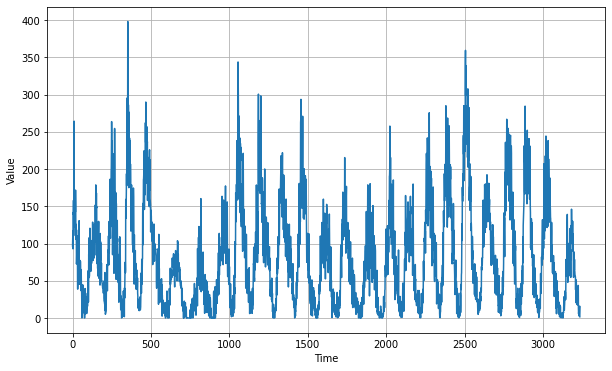

In [5]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 60
batch_size = 32
shuffle_buffer_size = 1000

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

2022-08-10 21:36:52.806512: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


<PrefetchDataset shapes: ((None, None, 1), (None, 1)), types: (tf.float64, tf.float64)>
(3000,)


2022-08-10 21:36:52.915334: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-10 21:36:52.916127: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-10 21:36:52.917306: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-10 21:36:52.917623: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

## Build the model

In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                           strides=1, padding="causal",
                           activation="relu",
                           input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10 ** (epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

2022-08-10 21:36:56.405386: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-08-10 21:37:00.205902: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


12/12 [==============================] - 11s 29ms/step - loss: 81.4328 - mae: 81.9305
Epoch 2/100
12/12 [==============================] - 1s 32ms/step - loss: 80.2590 - mae: 80.7567
Epoch 3/100
12/12 [==============================] - 1s 31ms/step - loss: 78.5311 - mae: 79.0287
Epoch 4/100
12/12 [==============================] - 1s 32ms/step - loss: 76.5364 - mae: 77.0339
Epoch 5/100
12/12 [==============================] - 1s 35ms/step - loss: 74.4509 - mae: 74.9484
Epoch 6/100
12/12 [==============================] - 1s 33ms/step - loss: 72.3866 - mae: 72.8840
Epoch 7/100
12/12 [==============================] - 1s 33ms/step - loss: 70.4372 - mae: 70.9347
Epoch 8/100
12/12 [==============================] - 1s 34ms/step - loss: 68.6067 - mae: 69.1043
Epoch 9/100
12/12 [==============================] - 1s 31ms/step - loss: 66.9549 - mae: 67.4526
Epoch 10/100
12/12 [==============================] - 1s 30ms/step - loss: 65.4669 - mae: 65.9646
Epoch 11/100
12/12 [====================

## Visualize metrics

(1e-08, 0.0001, 0.0, 60.0)

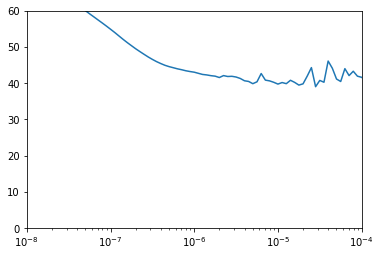

In [9]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

## Retrain the model with optimized hyperparmeters

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                           strides=1, padding="causal",
                           activation="relu",
                           input_shape=[None, 1]),
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=500)

Epoch 1/500
30/30 [==============================] - 3s 17ms/step - loss: 51.2724 - mae: 51.7703
Epoch 2/500
30/30 [==============================] - 1s 18ms/step - loss: 41.6317 - mae: 42.1290
Epoch 3/500
30/30 [==============================] - 1s 30ms/step - loss: 40.7372 - mae: 41.2345
Epoch 4/500
30/30 [==============================] - 1s 19ms/step - loss: 40.4431 - mae: 40.9402
Epoch 5/500
30/30 [==============================] - 1s 18ms/step - loss: 39.9478 - mae: 40.4450
Epoch 6/500
30/30 [==============================] - 1s 17ms/step - loss: 40.4355 - mae: 40.9327
Epoch 7/500
30/30 [==============================] - 1s 18ms/step - loss: 40.3471 - mae: 40.8443
Epoch 8/500
30/30 [==============================] - 1s 17ms/step - loss: 39.5472 - mae: 40.0445
Epoch 9/500
30/30 [==============================] - 1s 17ms/step - loss: 38.5969 - mae: 39.0940
Epoch 10/500
30/30 [==============================] - 1s 17ms/step - loss: 38.3981 - mae: 38.8952
Epoch 11/500
30/30 [=========

## Forcasting using the trained model

25.20547


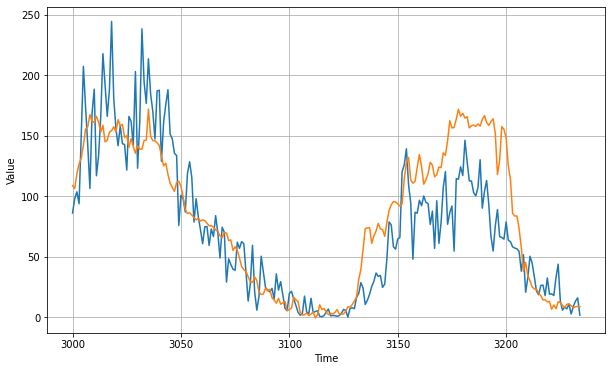

In [11]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

print(tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy())